<a href="https://colab.research.google.com/github/johnyu1234/Food_Classification/blob/main/FoodClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, sys
import _pickle as pickle
from keras.utils import np_utils
import numpy as np
import glob
import random
!rm -rf dataset
!git clone https://github.com/johnyu1234/dataset.git

Cloning into 'dataset'...
remote: Enumerating objects: 97, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 7263 (delta 8), reused 90 (delta 5), pack-reused 7166
Receiving objects: 100% (7263/7263), 407.68 MiB | 47.97 MiB/s, done.
Resolving deltas: 100% (12/12), done.
Checking out files: 100% (7226/7226), done.


# New Section

In [ ]:
!pip install efficientnet

In [ ]:
from keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    directory=r"./dataset/train/",
    target_size=(112, 112),
    color_mode="rgb",
    batch_size=6,
    class_mode="categorical",
    seed=42,
    shuffle=True,
    subset="training"
)
validation_generator = train_datagen.flow_from_directory(
   directory=r"./dataset/train/",
    target_size=(112, 112),
    color_mode="rgb",
    batch_size=6,
    class_mode="categorical",
    seed=42,
    shuffle=True,
    subset='validation') # set as validation data
test_generator = train_datagen.flow_from_directory(
    directory=r"./dataset/test/",
    target_size=(112, 112),
    color_mode="rgb",
    batch_size=6,
    class_mode="categorical",
    seed=42,
    shuffle=False
)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
labels_test = (test_generator.class_indices)
labels_test = dict((v,k) for k,v in labels_test.items())
print(validation_generator.classes[1])
print(validation_generator.filenames[1])
print(labels)
print(labels_test)

In [ ]:
import numpy 
import efficientnet.keras as efn 
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Flatten,Dropout
from keras.layers.normalization import BatchNormalization
#standardizes the inputs to a layer for each mini-batch. 
#This has the effect of stabilizing the learning process 
#and dramatically reducing the number of training epochs required to train deep networks
model = Sequential()
#model.add(VGG16(weights='imagenet', include_top=False,classes = 4,input_shape=(224,224,3)))
model.add(efn.EfficientNetB7(include_top=False, weights="imagenet", classes=10,input_shape=(112,112,3)))
model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

optimizer = Adam(learning_rate=1e-4)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Functional) (None, 4, 4, 2560)        64097680  
_________________________________________________________________
flatten_2 (Flatten)          (None, 40960)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 4096)              167776256 
_________________________________________________________________
batch_normalization_2 (Batch (None, 4096)              16384     
_________________________________________________________________
dropout_2 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                40970     
Total params: 231,931,290
Trainable params: 231,612,378
Non-trainable params: 318,912
__________________________________

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size
hist = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=20
)

Epoch 1/20
839/839 [==============================] - 191s 227ms/step - loss: 2.6365 - accuracy: 0.3575 - val_loss: 1.5116 - val_accuracy: 0.5654
Epoch 2/20
839/839 [==============================] - 186s 222ms/step - loss: 1.7909 - accuracy: 0.4727 - val_loss: 1.2687 - val_accuracy: 0.6188
Epoch 3/20
839/839 [==============================] - 187s 223ms/step - loss: 1.5039 - accuracy: 0.5381 - val_loss: 1.0195 - val_accuracy: 0.7049
Epoch 4/20
839/839 [==============================] - 187s 223ms/step - loss: 1.2965 - accuracy: 0.5930 - val_loss: 0.7897 - val_accuracy: 0.7648
Epoch 5/20
839/839 [==============================] - 186s 222ms/step - loss: 1.2423 - accuracy: 0.6128 - val_loss: 0.9451 - val_accuracy: 0.7337
Epoch 6/20
839/839 [==============================] - 186s 222ms/step - loss: 1.0964 - accuracy: 0.6552 - val_loss: 0.8022 - val_accuracy: 0.7656
Epoch 7/20
839/839 [==============================] - 186s 222ms/step - loss: 1.0179 - accuracy: 0.6743 - val_loss: 0.7615 -

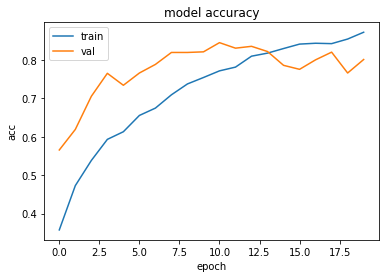

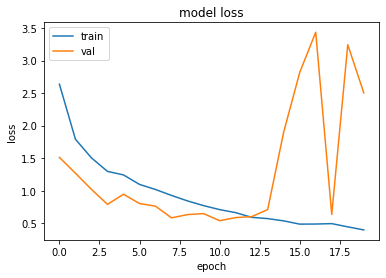

In [ ]:
import matplotlib.pyplot as plt


plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from keras.models import load_model

model.save('effnb7_dropout.h5')

KeyboardInterrupt: ignored

In [ ]:
score, acc = model.evaluate_generator(generator=validation_generator,steps=STEP_SIZE_VALID)
print('Test loss:', score)
print('Test accuracy:', acc)

test_generator.reset()
pred=model.predict_generator(test_generator,verbose=1)
print(type(pred))
print(pred)
predicted_class_indices=np.argmax(pred,axis=1)
predictions = [labels[k] for k in predicted_class_indices]
#print(predicted_class_indices)
test = [labels_test[k] for k in test_generator.classes]
#print(test_generator.classes)



Test loss: 2.6694188117980957
Test accuracy: 0.8157894611358643
157/157 [==============================] - 9s 57ms/step
<class 'numpy.ndarray'>
[[7.0935148e-01 1.1862910e-05 1.6545871e-01 ... 5.4102413e-02
  6.9599228e-05 2.3609193e-02]
 [9.9881411e-01 1.9127236e-05 7.9828256e-05 ... 8.2882005e-05
  5.5897937e-07 6.3667801e-04]
 [9.9362069e-01 1.7808137e-06 5.4363911e-03 ... 3.8386330e-05
  4.5955894e-06 3.4563121e-04]
 ...
 [5.6448858e-05 6.0635416e-06 5.0519302e-04 ... 4.1134720e-04
  6.6483139e-05 9.9470830e-01]
 [4.4324433e-06 7.4241420e-06 3.6318518e-08 ... 7.7878540e-05
  2.1739802e-01 7.8221095e-01]
 [3.8759734e-02 1.7415659e-05 9.6092379e-01 ... 4.1589824e-06
  2.1010138e-07 2.4743710e-04]]


In [ ]:
# to see every specific error
check = []
total = []
for i in range(len(labels)):
    check.append(0)
    total.append(0)
for i in range(len(test_generator.classes)):
  total[test_generator.classes[i]]+=1
  if (predicted_class_indices[i]!=test_generator.classes[i]):
        print(i)
        check[test_generator.classes[i]]+=1
        print("Predicted:",predictions[i],"Actual:",test[i])
        print(test_generator.filenames[i])


11
Predicted: omelette Actual: apple_pie
apple_pie/134.jpg
16
Predicted: baklava Actual: apple_pie
apple_pie/168971.jpg
21
Predicted: miso_soup Actual: apple_pie
apple_pie/202741.jpg
37
Predicted: omelette Actual: apple_pie
apple_pie/257377.jpg
40
Predicted: omelette Actual: apple_pie
apple_pie/262170.jpg
53
Predicted: baklava Actual: apple_pie
apple_pie/299931.jpg
55
Predicted: omelette Actual: apple_pie
apple_pie/305590.jpg
59
Predicted: omelette Actual: apple_pie
apple_pie/330431.jpg
65
Predicted: baklava Actual: apple_pie
apple_pie/360406.jpg
71
Predicted: baby_back_ribs Actual: apple_pie
apple_pie/395303.jpg
79
Predicted: tiramisu Actual: apple_pie
apple_pie/412545.jpg
81
Predicted: omelette Actual: apple_pie
apple_pie/418685.jpg
83
Predicted: baklava Actual: apple_pie
apple_pie/420768.jpg
88
Predicted: omelette Actual: apple_pie
apple_pie/440497.jpg
89
Predicted: omelette Actual: apple_pie
apple_pie/451719.jpg
91
Predicted: baklava Actual: apple_pie
apple_pie/456190.jpg
94
Predic

Wrong Prediction
apple_pie
wrong predictions:  22 / 128
Accuracy: 82.8125 %
baby_back_ribs
wrong predictions:  12 / 128
Accuracy: 90.625 %
baklava
wrong predictions:  32 / 128
Accuracy: 75.0 %
banana
wrong predictions:  1 / 21
Accuracy: 95.23809523809523 %
instant_noodle
wrong predictions:  0 / 14
Accuracy: 100.0 %
miso_soup
wrong predictions:  41 / 128
Accuracy: 67.96875 %
omelette
wrong predictions:  20 / 128
Accuracy: 84.375 %
rice
wrong predictions:  2 / 2
Accuracy: 0.0 %
spring_rolls
wrong predictions:  22 / 128
Accuracy: 82.8125 %
tiramisu
wrong predictions:  36 / 128
Accuracy: 71.875 %


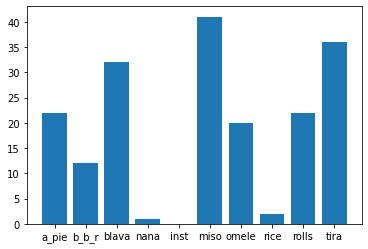

In [ ]:
# compilation of all erorr
print("Wrong Prediction")
for i in range(len(check)):
  print(labels[i])
  print("wrong predictions: ",check[i],"/",total[i])
  print("Accuracy:",((total[i]-check[i])/total[i])*100,"%")
 
labeling = ["a_pie","b_b_r","blava","nana","inst","miso","omele","rice","rolls","tira"]
plt.bar(labeling,check)
plt.show()

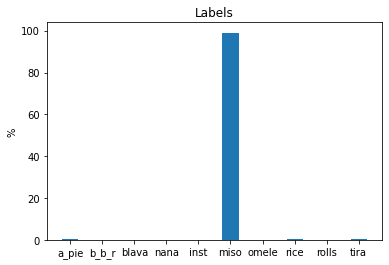

In [ ]:
# show the predictions of each labels
from google.colab.patches import cv2_imshow
y_pos=[0,10,20,30,40,50,60,70,80,90]
# {0: 'apple_pie', 1: 'baby_back_ribs', 2: 'baklava', 3: 'instant_noodle', 4: 'miso_soup', 5: 'omelette', 6: 'spring_rolls', 7: 'tiramisu'}
labeling = ["a_pie","b_b_r","blava","nana","inst","miso","omele","rice","rolls","tira"]
performance=np.abs(pred[676]*100)
#print(performance)
plot1=plt.figure(1)
plt.bar(y_pos, performance, align='center', alpha=1,width=5)
#plt.xticks(y_pos,test_generator.class_indices)
plt.xticks(y_pos,labeling)
plt.ylabel('%')
plt.title('Labels')
plt.show()  

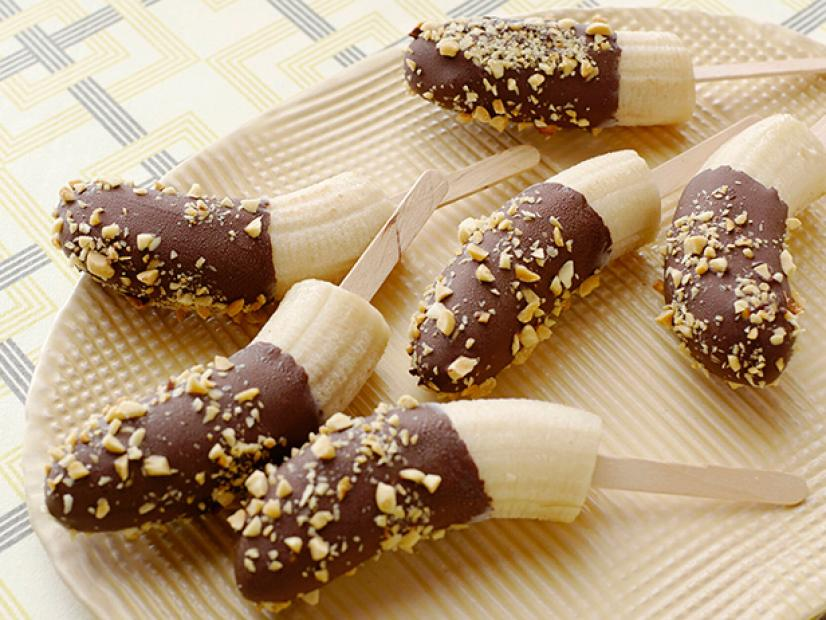

In [ ]:
# to see what kind of pictures are in the dataset
from google.colab.patches import cv2_imshow
import cv2
loc=r"./dataset/test/"+test_generator.filenames[384]
img = cv2.imread(loc) 
cv2_imshow(img)
